#### Для корректной работы нужно
* переместить файлы test.csv & train.csv в директорию data/
* скачать [graphviz](http://www.graphviz.org/download)  
* вылетает ошибка [“dot.exe” not found in path](https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7)

In [1]:
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, roc_auc_score,precision_score,accuracy_score,roc_curve,make_scorer
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,record_id
0,15000.0,36 months,11.99,498.15,B,B3,Quality Assurance Specialist,4 years,MORTGAGE,70000.0,...,32.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,295215.0,20500.0,453246940
1,3725.0,36 months,6.03,113.38,A,A1,NaN,NaN,MORTGAGE,52260.0,...,9.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,25130.0,14200.0,453313687
2,16000.0,36 months,11.14,524.89,B,B2,KIPP NYC,3 years,RENT,67500.0,...,22.0,f,0.0,1.0,INDIVIDUAL,0.0,193.0,41737.0,19448.0,453283543
3,4200.0,36 months,13.33,142.19,C,C3,Receptionist,< 1 year,MORTGAGE,21600.0,...,19.0,w,0.0,1.0,INDIVIDUAL,0.0,165.0,28187.0,14500.0,453447199
4,6500.0,36 months,12.69,218.05,B,B5,Medtox Laboratories,10+ years,RENT,41000.0,...,12.0,f,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,453350283


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 36 columns):
loan_amnt                     200189 non-null float64
term                          200189 non-null object
int_rate                      200189 non-null float64
installment                   200189 non-null float64
grade                         200189 non-null object
sub_grade                     200189 non-null object
emp_title                     189062 non-null object
emp_length                    192135 non-null object
home_ownership                200189 non-null object
annual_inc                    200189 non-null float64
verification_status           200189 non-null object
issue_d                       200189 non-null object
loan_status                   200189 non-null int64
pymnt_plan                    200189 non-null object
purpose                       200189 non-null object
zip_code                      200189 non-null object
addr_state                    200189 n

* int_rate - Interest Rate on the loan
* annual_inc - Theannual income provided by the borrower during registration
* inq_last_6mths -The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* mths_since_last_delinq  - Months since most recent personal finance delinquency.
* pub_rec  - Number of derogatory public records
* revolBal - Total credit revolving balance
* revolUtil - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* loan_amnt  - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* installment - The monthly payment owed by the borrower if the loan originates.
* home_ownership    
* emp_title                   
* annual_inc                  
* verification_status  - Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
* purpose                 
* dti -  A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* open_acc                  
* total_acc                    
* initial_list_status - The initial listing status of the loan. Possible values are – W, F           
* collections_12_mths_ex_med - Number of collections in 12 months excluding medical collections
* application_type - Indicates whether the loan is an individual application or a joint application with two co-borrowers
* acc_now_delinq - The number of accounts on which the borrower is now delinquent.


## Начальная обработка данных:

In [4]:
def Nan_killer(x):
   # x['collections_12_mths_ex_med'] = x['collections_12_mths_ex_med'].fillna(0)
    x['revol_util'] = x['revol_util'].fillna(-999)
    x['tot_coll_amt'] = x['tot_coll_amt'].fillna(-999)
    x['tot_cur_bal'] =  x['tot_cur_bal'].fillna(-999)

In [5]:
def proc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
    x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
    x_train['application_type'] = x_train['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
    x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
    x_test['application_type'] = x_test['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
    x_train = pd.get_dummies(x_train, columns = ['purpose','grade','home_ownership'])   # OHE (?????)
    x_test = pd.get_dummies(x_test, columns = ['purpose','grade','home_ownership'])
    for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
        if i not in list(x_train):
            list(my_dataframe)
            x_test.drop(i, axis=1, inplace=True)
    for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
        if i not in list(x_test):
            x_test[i] = 0
    

    x_test = x_test.reindex(sorted(x_test.columns), axis=1)
    x_train = x_train.reindex(sorted(x_test.columns), axis=1)
    return x_train, x_test, y_train, y_test

## Функция для отображения метрик:
* ROC-AUC
* precision
* recall
* accuracy

In [5]:

def show_scores(model, x_test, y_test):
    pred =  model.predict(x_test)
    print('Recall: %.2f' % recall_score(y_test,pred))
    print('Precision score: %.2f' % precision_score(y_test,pred))
    print('Accuracy score: %.2f' % accuracy_score(y_test, pred))
 

In [6]:
def plot_roc(model, x_test, y_test):  
    pred = model.predict_proba(x_test)
    print("ROC-AUC score: ", roc_auc_score(y_test, pred[:, 1]))
    fpr, tpr,_=roc_curve(y_test,pred[:, 1],drop_intermediate=True)
    plt.figure()
    plt.plot(fpr, tpr, color='red',
            lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

# Регрессия

In [38]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

In [191]:
y = train[train['int_rate'] >= 0]['int_rate'] # целевой признак
x = train.loc[:,['annual_inc','collections_12_mths_ex_med','initial_list_status',
                 'installment','open_acc','total_acc','dti','purpose',
                 'grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','loan_status',
                 'tot_coll_amt','loan_amnt','application_type','acc_now_delinq' ] ] # параметры
x.info()

In [195]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 15 columns):
annual_inc             200189 non-null float64
initial_list_status    200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
grade                  200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
loan_status            200189 non-null int64
tot_coll_amt           200189 non-null float64
loan_amnt              200189 non-null float64
dtypes: float64(10), int64(1), object(4)
memory usage: 22.9+ MB


In [196]:
x.nunique()

annual_inc             16284
initial_list_status        2
installment            41347
open_acc                  58
total_acc                105
dti                     3975
purpose                   14
grade                      7
home_ownership             6
inq_last_6mths             9
revol_bal              44045
revol_util              1180
loan_status                2
tot_coll_amt            3646
loan_amnt               1317
dtype: int64

In [42]:
x_train, x_test, y_train, y_test = proc(x,y)

In [43]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null int64
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-nul

In [44]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60057 entries, 8644 to 191094
Data columns (total 43 columns):
acc_now_delinq                60057 non-null float64
annual_inc                    60057 non-null float64
application_type              60057 non-null int64
collections_12_mths_ex_med    60057 non-null float64
dti                           60057 non-null float64
grade_A                       60057 non-null uint8
grade_B                       60057 non-null uint8
grade_C                       60057 non-null uint8
grade_D                       60057 non-null uint8
grade_E                       60057 non-null uint8
grade_F                       60057 non-null uint8
grade_G                       60057 non-null uint8
home_ownership_ANY            60057 non-null int64
home_ownership_MORTGAGE       60057 non-null uint8
home_ownership_NONE           60057 non-null uint8
home_ownership_OTHER          60057 non-null uint8
home_ownership_OWN            60057 non-null uint8
home_ownersh

## Линейная регрессия  + Дерево решений (регрессия)

In [15]:
lm = linear_model.Lasso(alpha=0.01,random_state = 42).fit(x_train,y_train)
dec_reg = DecisionTreeRegressor(criterion='mse',max_depth=10, random_state=42, min_samples_leaf = 3).fit(x_train,y_train)

In [16]:
from sklearn.metrics import r2_score

In [17]:
r2_score(y_test, lm.predict(x_test))

0.9146765103292894

In [18]:
r2_score(y_test, dec_reg.predict(x_test))

0.9280174951473175

# Бинарная классификация

In [7]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt',] ] # параметры
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [8]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
tot_coll_amt           200189 non-null float64
loan_amnt              200189 non-null float64
dt

In [172]:
x_train, x_test, y_train, y_test = proc(x,y)

KeyError: "['grade'] not in index"

In [ ]:
x_train.info()

In [12]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null bool
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-null

## Логистическая регрессия

In [24]:
from sklearn import linear_model

In [25]:
lr = linear_model.LogisticRegression(solver='liblinear',random_state=42).fit(x_train, y_train)
lr.predict(x_test)
show_scores(lr, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


ROC-AUC score:  0.5877202844814491


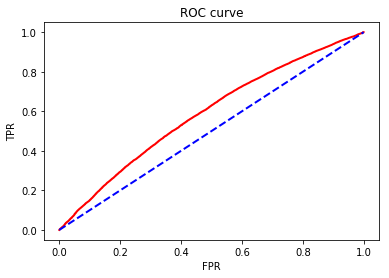

In [26]:
plot_roc(lr, x_test, y_test)

## Дерево решений (классификация)

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
clf_tree = DecisionTreeClassifier(criterion='entropy',splitter = 'random', max_depth=12, random_state=42, min_samples_leaf = 3)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random')

In [29]:
show_scores(clf_tree, x_test, y_test)

Recall: 0.97
Precision score: 0.79
Accuracy score: 0.77


ROC-AUC score:  0.6742598095246735


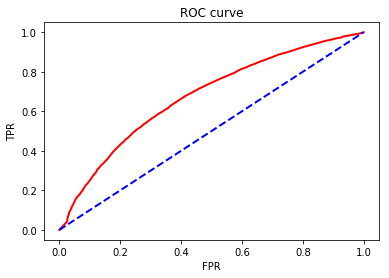

In [30]:
plot_roc(clf_tree, x_test, y_test)

## Случайный лес

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [32]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [12,10,8],
#    'min_samples_leaf': [1,3,5,7],
#    'n_estimators': [80,100,200,500],
#    'criterion' : ['entropy','gini'],
#}
#score = make_scorer(roc_auc_score)
#rf =  RandomForestClassifier(random_state = 42)
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 5, n_jobs = -1, verbose = 2, scoring=score)
#grid_search.fit(x_train,  y_train)
#grid_search.best_params_
# best_grid = grid_search.best_estimator_

In [33]:
best_grid = RandomForestClassifier(random_state = 42, bootstrap = True, 
                                   max_depth = 12, min_samples_leaf = 1,
                                   n_estimators = 80, criterion = 'entropy')
best_grid.fit(x_train,  y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [34]:
best_grid.predict(x_test)
show_scores(best_grid, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7019092486975207


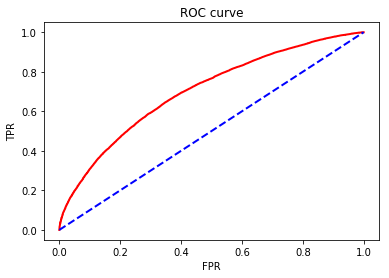

In [35]:
plot_roc(best_grid, x_test, y_test)

## VotingClassifier

In [36]:
from sklearn.ensemble import VotingClassifier

In [37]:
voting_clf = VotingClassifier(estimators=[('lr', lr), ('rf', best_grid)],voting='soft')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...mators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [38]:
show_scores(voting_clf, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


ROC-AUC score:  0.6850833952966429


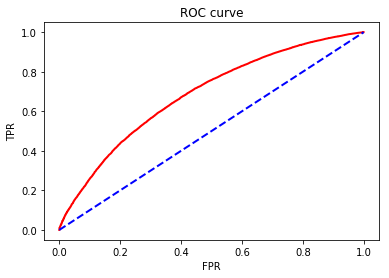

In [ ]:
plot_roc(voting_clf, x_test, y_test)

## Xgboost (Grid search)

[Параметры XGBClassifier](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [8]:
import xgboost as xgb

In [42]:
xgbst = xgb.XGBClassifier(
                           max_depth=3,
                           min_child_weight=3, #Defines the minimum sum of weights of all observations required
                           gamma = 0.25, 
                                    #A node is split only when the resulting split gives a positive 
                                    #reduction in the loss function. Gamma specifies the minimum loss 
                                    #reduction required to make a split.in a child
                           eval_metric = 'auc',                         
                           subsample= 0.52,
                                    #Denotes the fraction of observations to be randomly sampled for each tree
                           colsample_bytree=0.95, #The number of features to consider while searching for the best split
                           reg_alpha= 5,# L1 regularization term on weights
                           reg_lambda=0,# L2 regularization term on weights.
                           learning_rate = 0.01,
                           n_estimators =4000,
                           objective='binary:logistic',
                           
                           verbosity  = 2, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
                          
                           scale_pos_weight=1, #Control the balance of positive and negative weights, useful for unbalanced classes
                           seed=20,
                           random_state= 42,
                           missing=None)

In [ ]:
xgbst.fit(x_train, y_train)

In [ ]:
show_scores(xgbst, x_train, y_train)

In [ ]:
show_scores(xgbst, x_test, y_test)

In [ ]:
plot_roc(xgbst, x_train, y_train)

In [ ]:
plot_roc(xgbst, x_test, y_test)

## Xgboost (Hypetopt)

In [13]:
from sklearn.metrics import r2_score
from hyperopt import tpe, hp, fmin
import xgboost as xgb
from hyperopt.mongoexp import MongoTrials

In [14]:
def func(args):
    loss = 0
    if args['model'] == xgb.XGBClassifier:
        max_depth = args['param']['max_depth']
        min_child_weight = args['param']['min_child_weight']
        gamma = args['param']['gamma']
        subsample = args['param']['subsample']
        colsample_bytree = args['param']['colsample_bytree']
        reg_alpha = args['param']['reg_alpha']
        clf = xgb.XGBClassifier(eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.1,
                               n_estimators=1000,    
                               reg_lambda=0,
                               max_depth = max_depth,
                               min_child_weight =min_child_weight,
                               gamma =  gamma,
                               subsample = subsample,
                               colsample_bytree = colsample_bytree,
                               reg_alpha = reg_alpha)
        clf.fit(x_train,y_train)
        y_pred_train = clf.predict_proba(x_train)
        loss =  roc_auc_score(y_train, y_pred_train[:, 1])
        print("Test Score:",clf.score(x_test,y_test))
        print("Train Score:",clf.score(x_train,y_train))
        print("\n=================")
    return -loss


In [14]:
space = hp.choice('classifier',[
        {
        'model': xgb.XGBClassifier,
        'param': {
        'max_depth' : hp.choice('max_depth',range(3,10,2)),
        'min_child_weight' : hp.choice('min_child_weight', range(1,6,2)),
        'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
        'subsample' : hp.choice('subsample', [i/10.0 for i in range(6,10)]),
        'colsample_bytree'  : hp.choice('colsample_bytree', [i/10.0 for i in range(6,10)]),
        'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 100])  
        }}
        ])
space

In [16]:
# trials = MongoTrials('mongo://localhost:27017/foo_db/jobs',exp_key='exp1')

In [15]:
# best = fmin(func,space,algo=tpe.suggest,max_evals=100)
best = {'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [16]:
best

{'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [25]:
bst = xgb.XGBClassifier(     eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.01,
                               n_estimators=4000,    
                               reg_lambda=0,
                               seed = 20,
                               max_depth = best['max_depth'],
                               min_child_weight = best['min_child_weight'],
                               gamma =  best['gamma'],
                               subsample = 0.52,
                               colsample_bytree = best['colsample_bytree'],
                               reg_alpha = best['reg_alpha'])

In [26]:
bst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=1, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=0, missing=None,
       n_estimators=4000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=3,
       reg_lambda=0, scale_pos_weight=1, seed=20, silent=True,
       subsample=0.52, verbosity=2)

In [34]:
show_scores(bst, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7115789901232025


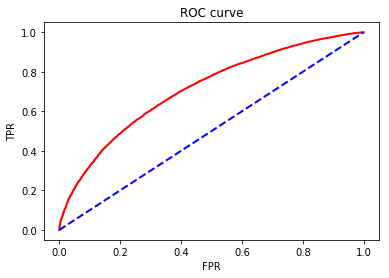

In [35]:
plot_roc(bst, x_test, y_test)

## Catboost

In [9]:
from hyperopt import tpe, hp, fmin
import hyperopt 

In [10]:
x['purpose'].value_counts()

debt_consolidation    117953
credit_card            39337
home_improvement       11855
other                  11304
major_purchase          4865
small_business          3757
car                     2813
medical                 2273
moving                  1645
wedding                 1451
house                   1272
vacation                1220
educational              244
renewable_energy         200
Name: purpose, dtype: int64

In [11]:
x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [12]:
x['purpose'].value_counts()

debt_consolidation    117953
credit_card            39337
other                  31044
home_improvement       11855
Name: purpose, dtype: int64

In [13]:
x['home_ownership'].value_counts()

MORTGAGE    98279
RENT        84233
OWN         17542
OTHER         101
NONE           33
ANY             1
Name: home_ownership, dtype: int64

In [14]:
x['home_ownership'] = x['home_ownership'].astype(str).map(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)

In [15]:
x['home_ownership'].value_counts()

MORTGAGE    98279
RENT        84233
OWN         17542
OTHER         135
Name: home_ownership, dtype: int64

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
# x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
# x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['sub_grade'] = x_test['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
x_train['sub_grade'] = x_train['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
# x_train = pd.get_dummies(x_train, columns = ['purpose','home_ownership'])   # OHE (?????)
# x_test = pd.get_dummies(x_test, columns = ['purpose','home_ownership'])
#for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
#    if i not in list(x_train):
#        list(my_dataframe)
#        x_test.drop(i, axis=1, inplace=True)
#for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
#    if i not in list(x_test):
#         x_test[i] = 0   

#x_test = x_test.reindex(sorted(x_test.columns), axis=1)
#x_train = x_train.reindex(sorted(x_test.columns), axis=1)

In [17]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc             140132 non-null float64
verification_status    140132 non-null object
int_rate               140132 non-null float64
initial_list_status    140132 non-null object
term                   140132 non-null object
installment            140132 non-null float64
open_acc               140132 non-null float64
total_acc              140132 non-null float64
dti                    140132 non-null float64
purpose                140132 non-null object
tot_cur_bal            140132 non-null float64
sub_grade              140132 non-null int64
home_ownership         140132 non-null object
inq_last_6mths         140132 non-null float64
total_rev_hi_lim       106404 non-null float64
revol_bal              140132 non-null float64
revol_util             140132 non-null float64
tot_coll_amt           140132 non-null float64
loan_amnt              140132 non-null float6

In [18]:
x_train.head()

,annual_inc,verification_status,int_rate,initial_list_status,term,installment,open_acc,total_acc,dti,purpose,tot_cur_bal,sub_grade,home_ownership,inq_last_6mths,total_rev_hi_lim,revol_bal,revol_util,tot_coll_amt,loan_amnt
193136,75000.0,Source Verified,13.11,w,36 months,690.97,17.0,42.0,26.85,credit_card,223010.0,664,MORTGAGE,2.0,43599.0,38230.0,87.7,0.0,20475.0
27784,73000.0,Verified,15.99,f,36 months,421.83,18.0,38.0,16.47,debt_consolidation,230520.0,682,MORTGAGE,2.0,24100.0,9874.0,41.0,0.0,12000.0
157132,200000.0,Verified,8.90,f,36 months,508.06,14.0,37.0,13.50,debt_consolidation,488248.0,655,MORTGAGE,2.0,54800.0,34550.0,63.0,0.0,16000.0
81962,100000.0,Not Verified,15.33,f,36 months,417.94,17.0,36.0,20.48,debt_consolidation,-999.0,683,MORTGAGE,3.0,NaN,88599.0,60.9,-999.0,12000.0
161,65000.0,Verified,14.16,w,36 months,342.56,14.0,19.0,14.00,debt_consolidation,18270.0,672,RENT,2.0,25100.0,10948.0,43.6,0.0,10000.0


In [19]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'term', 'purpose',
       'home_ownership'],
      dtype='object')

In [20]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

[1, 3, 4, 9, 12]

In [21]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb
import frozendict
# roc_auc_score

In [39]:
params = {'learning_rate': 0.01,
          'depth': 9.0,
        #  'rsm': 0.8789580279825991,
          'l2_leaf_reg': 29.083288170330242,
          'task_type': 'CPU',
          'loss_function': 'Logloss',
          'eval_metric': 'AUC', 'od_type': 'Iter',
          'od_wait': 40,
          'custom_metric': ['AUC'],
          'iterations': 4000,
          'random_seed': 42}
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)


In [40]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.6814712	best: 0.6814712 (0)	total: 363ms	remaining: 24m 13s
1:	test: 0.6917602	best: 0.6917602 (1)	total: 685ms	remaining: 22m 50s
2:	test: 0.6928292	best: 0.6928292 (2)	total: 1.03s	remaining: 22m 58s
3:	test: 0.6939036	best: 0.6939036 (3)	total: 1.42s	remaining: 23m 39s
4:	test: 0.6937525	best: 0.6939036 (3)	total: 1.76s	remaining: 23m 24s
5:	test: 0.6946646	best: 0.6946646 (5)	total: 2.09s	remaining: 23m 10s
6:	test: 0.6947481	best: 0.6947481 (6)	total: 2.43s	remaining: 23m 4s
7:	test: 0.6950935	best: 0.6950935 (7)	total: 2.78s	remaining: 23m 6s
8:	test: 0.6956029	best: 0.6956029 (8)	total: 3.14s	remaining: 23m 10s
9:	test: 0.6956746	best: 0.6956746 (9)	total: 3.51s	remaining: 23m 20s
10:	test: 0.6958036	best: 0.6958036 (10)	total: 3.85s	remaining: 23m 16s
11:	test: 0.6971220	best: 0.6971220 (11)	total: 4.18s	remaining: 23m 10s
12:	test: 0.6976212	best: 0.6976212 (12)	total: 4.55s	remaining: 23m 14s
13:	test: 0.6979558	best: 0.6979558 (13)	total: 4.87s	remaining: 23m 6s
1

113:	test: 0.7027944	best: 0.7027944 (113)	total: 36.8s	remaining: 20m 53s
114:	test: 0.7027960	best: 0.7027960 (114)	total: 37s	remaining: 20m 50s
115:	test: 0.7028328	best: 0.7028328 (115)	total: 37.3s	remaining: 20m 49s
116:	test: 0.7028500	best: 0.7028500 (116)	total: 37.7s	remaining: 20m 50s
117:	test: 0.7028866	best: 0.7028866 (117)	total: 38s	remaining: 20m 50s
118:	test: 0.7029622	best: 0.7029622 (118)	total: 38.3s	remaining: 20m 50s
119:	test: 0.7030152	best: 0.7030152 (119)	total: 38.7s	remaining: 20m 50s
120:	test: 0.7030810	best: 0.7030810 (120)	total: 39s	remaining: 20m 51s
121:	test: 0.7031143	best: 0.7031143 (121)	total: 39.4s	remaining: 20m 51s
122:	test: 0.7031531	best: 0.7031531 (122)	total: 39.7s	remaining: 20m 51s
123:	test: 0.7031744	best: 0.7031744 (123)	total: 40s	remaining: 20m 51s
124:	test: 0.7031880	best: 0.7031880 (124)	total: 40.4s	remaining: 20m 52s
125:	test: 0.7032238	best: 0.7032238 (125)	total: 40.7s	remaining: 20m 52s
126:	test: 0.7032921	best: 0.7032

223:	test: 0.7063832	best: 0.7063832 (223)	total: 1m 12s	remaining: 20m 14s
224:	test: 0.7064124	best: 0.7064124 (224)	total: 1m 12s	remaining: 20m 14s
225:	test: 0.7064580	best: 0.7064580 (225)	total: 1m 12s	remaining: 20m 14s
226:	test: 0.7064921	best: 0.7064921 (226)	total: 1m 13s	remaining: 20m 13s
227:	test: 0.7065381	best: 0.7065381 (227)	total: 1m 13s	remaining: 20m 13s
228:	test: 0.7065695	best: 0.7065695 (228)	total: 1m 13s	remaining: 20m 13s
229:	test: 0.7065719	best: 0.7065719 (229)	total: 1m 14s	remaining: 20m 12s
230:	test: 0.7066040	best: 0.7066040 (230)	total: 1m 14s	remaining: 20m 11s
231:	test: 0.7066312	best: 0.7066312 (231)	total: 1m 14s	remaining: 20m 11s
232:	test: 0.7066748	best: 0.7066748 (232)	total: 1m 14s	remaining: 20m 11s
233:	test: 0.7066915	best: 0.7066915 (233)	total: 1m 15s	remaining: 20m 11s
234:	test: 0.7067313	best: 0.7067313 (234)	total: 1m 15s	remaining: 20m 11s
235:	test: 0.7067633	best: 0.7067633 (235)	total: 1m 15s	remaining: 20m 11s
236:	test: 0

333:	test: 0.7088746	best: 0.7088746 (333)	total: 1m 50s	remaining: 20m 7s
334:	test: 0.7089000	best: 0.7089000 (334)	total: 1m 50s	remaining: 20m 7s
335:	test: 0.7089168	best: 0.7089168 (335)	total: 1m 50s	remaining: 20m 6s
336:	test: 0.7089431	best: 0.7089431 (336)	total: 1m 51s	remaining: 20m 6s
337:	test: 0.7089718	best: 0.7089718 (337)	total: 1m 51s	remaining: 20m 6s
338:	test: 0.7089893	best: 0.7089893 (338)	total: 1m 51s	remaining: 20m 6s
339:	test: 0.7090063	best: 0.7090063 (339)	total: 1m 52s	remaining: 20m 5s
340:	test: 0.7090231	best: 0.7090231 (340)	total: 1m 52s	remaining: 20m 5s
341:	test: 0.7090414	best: 0.7090414 (341)	total: 1m 52s	remaining: 20m 5s
342:	test: 0.7090541	best: 0.7090541 (342)	total: 1m 53s	remaining: 20m 5s
343:	test: 0.7090750	best: 0.7090750 (343)	total: 1m 53s	remaining: 20m 5s
344:	test: 0.7090921	best: 0.7090921 (344)	total: 1m 53s	remaining: 20m 5s
345:	test: 0.7091220	best: 0.7091220 (345)	total: 1m 54s	remaining: 20m 5s
346:	test: 0.7091371	best

443:	test: 0.7105368	best: 0.7105368 (443)	total: 2m 27s	remaining: 19m 39s
444:	test: 0.7105498	best: 0.7105498 (444)	total: 2m 27s	remaining: 19m 39s
445:	test: 0.7105612	best: 0.7105612 (445)	total: 2m 27s	remaining: 19m 39s
446:	test: 0.7105708	best: 0.7105708 (446)	total: 2m 28s	remaining: 19m 38s
447:	test: 0.7105777	best: 0.7105777 (447)	total: 2m 28s	remaining: 19m 38s
448:	test: 0.7106070	best: 0.7106070 (448)	total: 2m 28s	remaining: 19m 38s
449:	test: 0.7106087	best: 0.7106087 (449)	total: 2m 29s	remaining: 19m 38s
450:	test: 0.7106197	best: 0.7106197 (450)	total: 2m 29s	remaining: 19m 37s
451:	test: 0.7106278	best: 0.7106278 (451)	total: 2m 30s	remaining: 19m 37s
452:	test: 0.7106376	best: 0.7106376 (452)	total: 2m 30s	remaining: 19m 37s
453:	test: 0.7106477	best: 0.7106477 (453)	total: 2m 30s	remaining: 19m 36s
454:	test: 0.7106484	best: 0.7106484 (454)	total: 2m 30s	remaining: 19m 35s
455:	test: 0.7106604	best: 0.7106604 (455)	total: 2m 31s	remaining: 19m 34s
456:	test: 0

552:	test: 0.7115399	best: 0.7115399 (552)	total: 3m 3s	remaining: 19m 2s
553:	test: 0.7115424	best: 0.7115424 (553)	total: 3m 3s	remaining: 19m 2s
554:	test: 0.7115499	best: 0.7115499 (554)	total: 3m 3s	remaining: 19m 1s
555:	test: 0.7115562	best: 0.7115562 (555)	total: 3m 4s	remaining: 19m 1s
556:	test: 0.7115663	best: 0.7115663 (556)	total: 3m 4s	remaining: 19m 1s
557:	test: 0.7115825	best: 0.7115825 (557)	total: 3m 4s	remaining: 19m
558:	test: 0.7115936	best: 0.7115936 (558)	total: 3m 5s	remaining: 19m
559:	test: 0.7115998	best: 0.7115998 (559)	total: 3m 5s	remaining: 19m
560:	test: 0.7116007	best: 0.7116007 (560)	total: 3m 5s	remaining: 18m 59s
561:	test: 0.7116009	best: 0.7116009 (561)	total: 3m 6s	remaining: 18m 58s
562:	test: 0.7116084	best: 0.7116084 (562)	total: 3m 6s	remaining: 18m 58s
563:	test: 0.7116081	best: 0.7116084 (562)	total: 3m 6s	remaining: 18m 57s
564:	test: 0.7116127	best: 0.7116127 (564)	total: 3m 7s	remaining: 18m 57s
565:	test: 0.7116195	best: 0.7116195 (565)

661:	test: 0.7122853	best: 0.7122853 (661)	total: 3m 39s	remaining: 18m 27s
662:	test: 0.7122953	best: 0.7122953 (662)	total: 3m 39s	remaining: 18m 26s
663:	test: 0.7123049	best: 0.7123049 (663)	total: 3m 40s	remaining: 18m 26s
664:	test: 0.7123111	best: 0.7123111 (664)	total: 3m 40s	remaining: 18m 26s
665:	test: 0.7123166	best: 0.7123166 (665)	total: 3m 40s	remaining: 18m 25s
666:	test: 0.7123194	best: 0.7123194 (666)	total: 3m 41s	remaining: 18m 25s
667:	test: 0.7123262	best: 0.7123262 (667)	total: 3m 41s	remaining: 18m 25s
668:	test: 0.7123305	best: 0.7123305 (668)	total: 3m 42s	remaining: 18m 25s
669:	test: 0.7123407	best: 0.7123407 (669)	total: 3m 42s	remaining: 18m 25s
670:	test: 0.7123408	best: 0.7123408 (670)	total: 3m 42s	remaining: 18m 25s
671:	test: 0.7123410	best: 0.7123410 (671)	total: 3m 43s	remaining: 18m 25s
672:	test: 0.7123425	best: 0.7123425 (672)	total: 3m 43s	remaining: 18m 24s
673:	test: 0.7123488	best: 0.7123488 (673)	total: 3m 43s	remaining: 18m 24s
674:	test: 0

770:	test: 0.7128431	best: 0.7128431 (770)	total: 4m 16s	remaining: 17m 52s
771:	test: 0.7128484	best: 0.7128484 (771)	total: 4m 16s	remaining: 17m 52s
772:	test: 0.7128539	best: 0.7128539 (772)	total: 4m 16s	remaining: 17m 51s
773:	test: 0.7128537	best: 0.7128539 (772)	total: 4m 17s	remaining: 17m 51s
774:	test: 0.7128639	best: 0.7128639 (774)	total: 4m 17s	remaining: 17m 51s
775:	test: 0.7128708	best: 0.7128708 (775)	total: 4m 17s	remaining: 17m 51s
776:	test: 0.7128722	best: 0.7128722 (776)	total: 4m 18s	remaining: 17m 50s
777:	test: 0.7128850	best: 0.7128850 (777)	total: 4m 18s	remaining: 17m 50s
778:	test: 0.7128910	best: 0.7128910 (778)	total: 4m 18s	remaining: 17m 50s
779:	test: 0.7128944	best: 0.7128944 (779)	total: 4m 19s	remaining: 17m 49s
780:	test: 0.7129066	best: 0.7129066 (780)	total: 4m 19s	remaining: 17m 49s
781:	test: 0.7129083	best: 0.7129083 (781)	total: 4m 19s	remaining: 17m 49s
782:	test: 0.7129116	best: 0.7129116 (782)	total: 4m 20s	remaining: 17m 48s
783:	test: 0

878:	test: 0.7133278	best: 0.7133278 (878)	total: 4m 52s	remaining: 17m 17s
879:	test: 0.7133261	best: 0.7133278 (878)	total: 4m 52s	remaining: 17m 17s
880:	test: 0.7133262	best: 0.7133278 (878)	total: 4m 53s	remaining: 17m 17s
881:	test: 0.7133349	best: 0.7133349 (881)	total: 4m 53s	remaining: 17m 17s
882:	test: 0.7133394	best: 0.7133394 (882)	total: 4m 53s	remaining: 17m 17s
883:	test: 0.7133411	best: 0.7133411 (883)	total: 4m 54s	remaining: 17m 17s
884:	test: 0.7133400	best: 0.7133411 (883)	total: 4m 54s	remaining: 17m 17s
885:	test: 0.7133405	best: 0.7133411 (883)	total: 4m 54s	remaining: 17m 16s
886:	test: 0.7133451	best: 0.7133451 (886)	total: 4m 55s	remaining: 17m 16s
887:	test: 0.7133424	best: 0.7133451 (886)	total: 4m 55s	remaining: 17m 16s
888:	test: 0.7133416	best: 0.7133451 (886)	total: 4m 56s	remaining: 17m 16s
889:	test: 0.7133461	best: 0.7133461 (889)	total: 4m 56s	remaining: 17m 16s
890:	test: 0.7133504	best: 0.7133504 (890)	total: 4m 56s	remaining: 17m 15s
891:	test: 0

987:	test: 0.7136674	best: 0.7136674 (987)	total: 5m 29s	remaining: 16m 45s
988:	test: 0.7136703	best: 0.7136703 (988)	total: 5m 30s	remaining: 16m 45s
989:	test: 0.7136738	best: 0.7136738 (989)	total: 5m 30s	remaining: 16m 45s
990:	test: 0.7136777	best: 0.7136777 (990)	total: 5m 30s	remaining: 16m 44s
991:	test: 0.7136811	best: 0.7136811 (991)	total: 5m 31s	remaining: 16m 44s
992:	test: 0.7136852	best: 0.7136852 (992)	total: 5m 31s	remaining: 16m 44s
993:	test: 0.7136866	best: 0.7136866 (993)	total: 5m 31s	remaining: 16m 43s
994:	test: 0.7136904	best: 0.7136904 (994)	total: 5m 32s	remaining: 16m 43s
995:	test: 0.7136973	best: 0.7136973 (995)	total: 5m 32s	remaining: 16m 43s
996:	test: 0.7136967	best: 0.7136973 (995)	total: 5m 33s	remaining: 16m 43s
997:	test: 0.7137003	best: 0.7137003 (997)	total: 5m 33s	remaining: 16m 42s
998:	test: 0.7137025	best: 0.7137025 (998)	total: 5m 33s	remaining: 16m 42s
999:	test: 0.7137111	best: 0.7137111 (999)	total: 5m 34s	remaining: 16m 42s
1000:	test: 

1093:	test: 0.7139733	best: 0.7139733 (1093)	total: 6m 6s	remaining: 16m 13s
1094:	test: 0.7139733	best: 0.7139733 (1093)	total: 6m 6s	remaining: 16m 12s
1095:	test: 0.7139791	best: 0.7139791 (1095)	total: 6m 6s	remaining: 16m 12s
1096:	test: 0.7139826	best: 0.7139826 (1096)	total: 6m 7s	remaining: 16m 11s
1097:	test: 0.7139848	best: 0.7139848 (1097)	total: 6m 7s	remaining: 16m 11s
1098:	test: 0.7139853	best: 0.7139853 (1098)	total: 6m 7s	remaining: 16m 11s
1099:	test: 0.7139879	best: 0.7139879 (1099)	total: 6m 8s	remaining: 16m 10s
1100:	test: 0.7139920	best: 0.7139920 (1100)	total: 6m 8s	remaining: 16m 10s
1101:	test: 0.7139891	best: 0.7139920 (1100)	total: 6m 8s	remaining: 16m 10s
1102:	test: 0.7139913	best: 0.7139920 (1100)	total: 6m 9s	remaining: 16m 9s
1103:	test: 0.7139909	best: 0.7139920 (1100)	total: 6m 9s	remaining: 16m 9s
1104:	test: 0.7139944	best: 0.7139944 (1104)	total: 6m 9s	remaining: 16m 9s
1105:	test: 0.7139986	best: 0.7139986 (1105)	total: 6m 10s	remaining: 16m 8s
11

1199:	test: 0.7141779	best: 0.7141818 (1193)	total: 6m 42s	remaining: 15m 39s
1200:	test: 0.7141761	best: 0.7141818 (1193)	total: 6m 42s	remaining: 15m 38s
1201:	test: 0.7141820	best: 0.7141820 (1201)	total: 6m 43s	remaining: 15m 38s
1202:	test: 0.7141875	best: 0.7141875 (1202)	total: 6m 43s	remaining: 15m 38s
1203:	test: 0.7141874	best: 0.7141875 (1202)	total: 6m 43s	remaining: 15m 37s
1204:	test: 0.7141881	best: 0.7141881 (1204)	total: 6m 44s	remaining: 15m 37s
1205:	test: 0.7141879	best: 0.7141881 (1204)	total: 6m 44s	remaining: 15m 37s
1206:	test: 0.7141910	best: 0.7141910 (1206)	total: 6m 44s	remaining: 15m 36s
1207:	test: 0.7141928	best: 0.7141928 (1207)	total: 6m 45s	remaining: 15m 36s
1208:	test: 0.7141938	best: 0.7141938 (1208)	total: 6m 45s	remaining: 15m 36s
1209:	test: 0.7142015	best: 0.7142015 (1209)	total: 6m 45s	remaining: 15m 35s
1210:	test: 0.7142083	best: 0.7142083 (1210)	total: 6m 46s	remaining: 15m 35s
1211:	test: 0.7142082	best: 0.7142083 (1210)	total: 6m 46s	remai

1305:	test: 0.7144472	best: 0.7144488 (1304)	total: 7m 19s	remaining: 15m 6s
1306:	test: 0.7144456	best: 0.7144488 (1304)	total: 7m 19s	remaining: 15m 6s
1307:	test: 0.7144481	best: 0.7144488 (1304)	total: 7m 20s	remaining: 15m 6s
1308:	test: 0.7144536	best: 0.7144536 (1308)	total: 7m 20s	remaining: 15m 5s
1309:	test: 0.7144532	best: 0.7144536 (1308)	total: 7m 21s	remaining: 15m 5s
1310:	test: 0.7144523	best: 0.7144536 (1308)	total: 7m 21s	remaining: 15m 5s
1311:	test: 0.7144515	best: 0.7144536 (1308)	total: 7m 21s	remaining: 15m 5s
1312:	test: 0.7144511	best: 0.7144536 (1308)	total: 7m 22s	remaining: 15m 4s
1313:	test: 0.7144499	best: 0.7144536 (1308)	total: 7m 22s	remaining: 15m 4s
1314:	test: 0.7144511	best: 0.7144536 (1308)	total: 7m 22s	remaining: 15m 4s
1315:	test: 0.7144561	best: 0.7144561 (1315)	total: 7m 23s	remaining: 15m 3s
1316:	test: 0.7144593	best: 0.7144593 (1316)	total: 7m 23s	remaining: 15m 3s
1317:	test: 0.7144633	best: 0.7144633 (1317)	total: 7m 24s	remaining: 15m 3s

1411:	test: 0.7146705	best: 0.7146706 (1409)	total: 7m 55s	remaining: 14m 31s
1412:	test: 0.7146706	best: 0.7146706 (1409)	total: 7m 55s	remaining: 14m 31s
1413:	test: 0.7146722	best: 0.7146722 (1413)	total: 7m 56s	remaining: 14m 30s
1414:	test: 0.7146741	best: 0.7146741 (1414)	total: 7m 56s	remaining: 14m 30s
1415:	test: 0.7146773	best: 0.7146773 (1415)	total: 7m 56s	remaining: 14m 30s
1416:	test: 0.7146749	best: 0.7146773 (1415)	total: 7m 57s	remaining: 14m 29s
1417:	test: 0.7146771	best: 0.7146773 (1415)	total: 7m 57s	remaining: 14m 29s
1418:	test: 0.7146816	best: 0.7146816 (1418)	total: 7m 57s	remaining: 14m 29s
1419:	test: 0.7146818	best: 0.7146818 (1419)	total: 7m 58s	remaining: 14m 28s
1420:	test: 0.7146876	best: 0.7146876 (1420)	total: 7m 58s	remaining: 14m 28s
1421:	test: 0.7146948	best: 0.7146948 (1421)	total: 7m 58s	remaining: 14m 28s
1422:	test: 0.7146903	best: 0.7146948 (1421)	total: 7m 59s	remaining: 14m 27s
1423:	test: 0.7146853	best: 0.7146948 (1421)	total: 7m 59s	remai

1517:	test: 0.7148727	best: 0.7148727 (1517)	total: 8m 30s	remaining: 13m 55s
1518:	test: 0.7148757	best: 0.7148757 (1518)	total: 8m 31s	remaining: 13m 55s
1519:	test: 0.7148740	best: 0.7148757 (1518)	total: 8m 31s	remaining: 13m 54s
1520:	test: 0.7148773	best: 0.7148773 (1520)	total: 8m 32s	remaining: 13m 54s
1521:	test: 0.7148823	best: 0.7148823 (1521)	total: 8m 32s	remaining: 13m 54s
1522:	test: 0.7148814	best: 0.7148823 (1521)	total: 8m 32s	remaining: 13m 53s
1523:	test: 0.7148825	best: 0.7148825 (1523)	total: 8m 33s	remaining: 13m 53s
1524:	test: 0.7148822	best: 0.7148825 (1523)	total: 8m 33s	remaining: 13m 53s
1525:	test: 0.7148860	best: 0.7148860 (1525)	total: 8m 33s	remaining: 13m 52s
1526:	test: 0.7148910	best: 0.7148910 (1526)	total: 8m 34s	remaining: 13m 52s
1527:	test: 0.7148948	best: 0.7148948 (1527)	total: 8m 34s	remaining: 13m 52s
1528:	test: 0.7148988	best: 0.7148988 (1528)	total: 8m 34s	remaining: 13m 51s
1529:	test: 0.7149019	best: 0.7149019 (1529)	total: 8m 35s	remai

1623:	test: 0.7150412	best: 0.7150433 (1621)	total: 9m 7s	remaining: 13m 20s
1624:	test: 0.7150434	best: 0.7150434 (1624)	total: 9m 7s	remaining: 13m 20s
1625:	test: 0.7150418	best: 0.7150434 (1624)	total: 9m 8s	remaining: 13m 20s
1626:	test: 0.7150397	best: 0.7150434 (1624)	total: 9m 8s	remaining: 13m 19s
1627:	test: 0.7150378	best: 0.7150434 (1624)	total: 9m 8s	remaining: 13m 19s
1628:	test: 0.7150411	best: 0.7150434 (1624)	total: 9m 9s	remaining: 13m 19s
1629:	test: 0.7150433	best: 0.7150434 (1624)	total: 9m 9s	remaining: 13m 19s
1630:	test: 0.7150413	best: 0.7150434 (1624)	total: 9m 9s	remaining: 13m 18s
1631:	test: 0.7150401	best: 0.7150434 (1624)	total: 9m 10s	remaining: 13m 18s
1632:	test: 0.7150434	best: 0.7150434 (1632)	total: 9m 10s	remaining: 13m 18s
1633:	test: 0.7150460	best: 0.7150460 (1633)	total: 9m 10s	remaining: 13m 17s
1634:	test: 0.7150455	best: 0.7150460 (1633)	total: 9m 11s	remaining: 13m 17s
1635:	test: 0.7150498	best: 0.7150498 (1635)	total: 9m 11s	remaining: 13

1729:	test: 0.7151829	best: 0.7151829 (1729)	total: 9m 44s	remaining: 12m 47s
1730:	test: 0.7151828	best: 0.7151829 (1729)	total: 9m 45s	remaining: 12m 47s
1731:	test: 0.7151900	best: 0.7151900 (1731)	total: 9m 45s	remaining: 12m 46s
1732:	test: 0.7151890	best: 0.7151900 (1731)	total: 9m 45s	remaining: 12m 46s
1733:	test: 0.7151892	best: 0.7151900 (1731)	total: 9m 46s	remaining: 12m 46s
1734:	test: 0.7151905	best: 0.7151905 (1734)	total: 9m 46s	remaining: 12m 45s
1735:	test: 0.7151917	best: 0.7151917 (1735)	total: 9m 46s	remaining: 12m 45s
1736:	test: 0.7151944	best: 0.7151944 (1736)	total: 9m 47s	remaining: 12m 44s
1737:	test: 0.7151973	best: 0.7151973 (1737)	total: 9m 47s	remaining: 12m 44s
1738:	test: 0.7152052	best: 0.7152052 (1738)	total: 9m 47s	remaining: 12m 44s
1739:	test: 0.7152099	best: 0.7152099 (1739)	total: 9m 48s	remaining: 12m 43s
1740:	test: 0.7152081	best: 0.7152099 (1739)	total: 9m 48s	remaining: 12m 43s
1741:	test: 0.7152106	best: 0.7152106 (1741)	total: 9m 48s	remai

1834:	test: 0.7152831	best: 0.7152835 (1833)	total: 10m 21s	remaining: 12m 12s
1835:	test: 0.7152837	best: 0.7152837 (1835)	total: 10m 21s	remaining: 12m 12s
1836:	test: 0.7152806	best: 0.7152837 (1835)	total: 10m 21s	remaining: 12m 12s
1837:	test: 0.7152789	best: 0.7152837 (1835)	total: 10m 22s	remaining: 12m 11s
1838:	test: 0.7152862	best: 0.7152862 (1838)	total: 10m 22s	remaining: 12m 11s
1839:	test: 0.7152866	best: 0.7152866 (1839)	total: 10m 22s	remaining: 12m 11s
1840:	test: 0.7152877	best: 0.7152877 (1840)	total: 10m 23s	remaining: 12m 10s
1841:	test: 0.7152845	best: 0.7152877 (1840)	total: 10m 23s	remaining: 12m 10s
1842:	test: 0.7152834	best: 0.7152877 (1840)	total: 10m 24s	remaining: 12m 10s
1843:	test: 0.7152869	best: 0.7152877 (1840)	total: 10m 24s	remaining: 12m 10s
1844:	test: 0.7152893	best: 0.7152893 (1844)	total: 10m 24s	remaining: 12m 9s
1845:	test: 0.7152899	best: 0.7152899 (1845)	total: 10m 25s	remaining: 12m 9s
1846:	test: 0.7152907	best: 0.7152907 (1846)	total: 10

In [41]:
show_scores(best_model, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7153219740280081


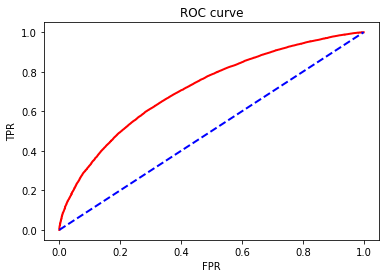

In [42]:
plot_roc(best_model, x_test, y_test)

In [26]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

sub_grade: 31.04988563127606
annual_inc: 12.691753630346401
tot_cur_bal: 9.015114273905393
dti: 8.787027326295647
term: 7.538263633594809
loan_amnt: 5.733295373809049
revol_bal: 4.629017530658202
revol_util: 4.197929503355747
purpose: 2.8612515752115724
total_acc: 2.6706240184804373
installment: 2.508467516909996
total_rev_hi_lim: 2.277051787101042
open_acc: 1.1822477841479648
home_ownership: 1.1238342482147639
tot_coll_amt: 1.067530396548466
inq_last_6mths: 1.0140627616057973
initial_list_status: 0.8277718454588077
verification_status: 0.8248711630798592
int_rate: 0.0


In [52]:
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 50

In [53]:
const_params = frozendict.frozendict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'od_type': 'Iter',
    'od_wait': 40,
    'custom_metric': ['AUC'],
    'iterations': 400,
    'random_seed':42})

In [54]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'rsm' :  hyper_params['rsm'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}

    def __call__(self, hyper_params):
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()        
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=42,
            verbose=False)
        min_mean_auc = np.min(scores['test-AUC-mean'])
        print('evaluated score={}'.format(min_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -min_mean_auc, 'status': hyperopt.STATUS_OK}

In [55]:

def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'depth': hp.quniform("depth", 4, 10, 1),
        'rsm': hp.uniform ('rsm', 0.75, 1.0),
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.01, 100)}
 
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=42))
    return best

def train_best_model(dataset, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization  
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params



In [ ]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.8661056258519679, 'depth': 6.0, 'rsm': 0.863675263055343, 'l2_leaf_reg': 6.914443573951684, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6739634197140681                                                                                     
evaluated 1 times                                                                                                      
evaluating params={'learning_rate': 0.7821805945418601, 'depth': 6.0, 'rsm': 0.8525259897133284, 'l2_leaf_reg': 93.28747120479488, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6751068015558621                                                                                     
evaluated 2 times                          

In [261]:
params

{'depth': 7.0,
 'l2_leaf_reg': 4.2312063872926355,
 'learning_rate': 0.29621731293760284,
 'rsm': 0.904269839625579,
 'task_type': 'CPU',
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'od_type': 'Iter',
 'od_wait': 40,
 'custom_metric': ['AUC'],
 'iterations': 400,
 'random_seed': 42}

ROC-AUC score:  0.699669049459066


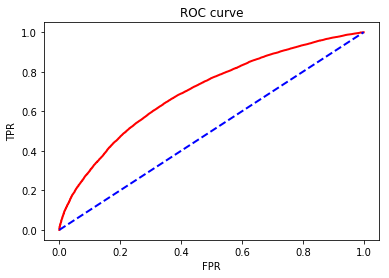

In [262]:
plot_roc(model, x_test, y_test)

In [263]:
show_scores(model, x_test, y_test)

Recall: 0.96
Precision score: 0.80
Accuracy score: 0.78


## LightGBM

In [33]:
import lightgbm as lgb

In [149]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
categorical_columns = x.columns[x.dtypes == 'object']
categorical_columns

Index(['initial_list_status', 'purpose', 'grade', 'home_ownership',
       'application_type'],
      dtype='object')

In [154]:
x_train['purpose'].value_counts()

debt_consolidation    82494
credit_card           27517
home_improvement       8322
other                  7876
major_purchase         3443
small_business         2665
car                    1964
medical                1589
moving                 1163
wedding                1028
house                   895
vacation                856
educational             182
renewable_energy        138
Name: purpose, dtype: int64

In [140]:
x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_train['application_type'] = x_train['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['application_type'] = x_test['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
categorical_columns = x.columns[x.dtypes == 'object']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc                    140132 non-null float64
int_rate                      140132 non-null float64
collections_12_mths_ex_med    140132 non-null float64
initial_list_status           140132 non-null bool
installment                   140132 non-null float64
open_acc                      140132 non-null float64
total_acc                     140132 non-null float64
dti                           140132 non-null float64
purpose                       140132 non-null object
grade                         140132 non-null object
home_ownership                140132 non-null object
inq_last_6mths                140132 non-null float64
pub_rec                       140132 non-null float64
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
tot_coll_amt                  140132 non-null float64
loan_amnt                 

In [127]:
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 20,
    'max_depth' : 6,
    'max_bin':100,
    'learning_rate':  0.35,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1' : 32,
    'verbose': 0}

In [128]:
params

{'boosting_type': 'dart',
 'objective': 'binary',
 'metric': {'auc'},
 'num_leaves': 20,
 'max_depth': 6,
 'max_bin': 100,
 'learning_rate': 0.35,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'lambda_l1': 32,
 'verbose': 0}

In [129]:
x_train.head()

,acc_now_delinq,annual_inc,application_type,collections_12_mths_ex_med,dti,grade_A,grade_B,grade_C,grade_D,grade_E,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,revol_bal,revol_util,tot_coll_amt,total_acc
193136,0.0,75000.0,True,0.0,26.85,0,1,0,0,0,...,0,0,0,0,0,0,38230.0,87.7,0.0,42.0
27784,0.0,73000.0,True,0.0,16.47,0,0,0,1,0,...,0,0,0,0,0,0,9874.0,41.0,0.0,38.0
157132,0.0,200000.0,True,0.0,13.50,1,0,0,0,0,...,0,0,0,0,0,0,34550.0,63.0,0.0,37.0
81962,0.0,100000.0,True,0.0,20.48,0,0,0,1,0,...,0,0,0,0,0,0,88599.0,60.9,0.0,36.0
161,0.0,65000.0,True,0.0,14.00,0,0,1,0,0,...,0,0,0,0,0,0,10948.0,43.6,0.0,19.0


In [130]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train, free_raw_data=False)

In [131]:
evals_result = {}

In [132]:
num_train, num_feature = x_train.shape
feature_name = ['feature_' + str(col) for col in range(num_feature)]

In [133]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=[lgb_train, lgb_eval],
               # feature_name=feature_name,              
              #  categorical_feature= categorical_features_indices,
             #   learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                evals_result=evals_result,
                verbose_eval=100)

[100]	training's auc: 0.720699	valid_1's auc: 0.708299
[200]	training's auc: 0.726036	valid_1's auc: 0.709584
[300]	training's auc: 0.730732	valid_1's auc: 0.710076
[400]	training's auc: 0.734714	valid_1's auc: 0.71066
[500]	training's auc: 0.738471	valid_1's auc: 0.710405
[600]	training's auc: 0.739775	valid_1's auc: 0.710752
[700]	training's auc: 0.742352	valid_1's auc: 0.711178
[800]	training's auc: 0.744439	valid_1's auc: 0.710858
[900]	training's auc: 0.746693	valid_1's auc: 0.710874
[1000]	training's auc: 0.748546	valid_1's auc: 0.710658
[1100]	training's auc: 0.750315	valid_1's auc: 0.709928
[1200]	training's auc: 0.751638	valid_1's auc: 0.709708
[1300]	training's auc: 0.75301	valid_1's auc: 0.709218
[1400]	training's auc: 0.755273	valid_1's auc: 0.708481
[1500]	training's auc: 0.756091	valid_1's auc: 0.708636
[1600]	training's auc: 0.757775	valid_1's auc: 0.708289
[1700]	training's auc: 0.759684	valid_1's auc: 0.708028
[1800]	training's auc: 0.761302	valid_1's auc: 0.707554
[19

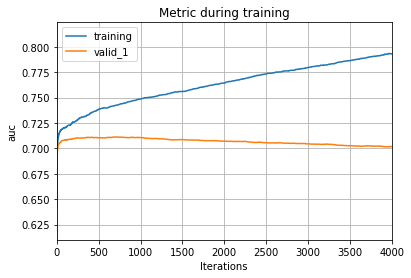

In [134]:
lgb.plot_metric(evals_result, metric='auc')
plt.show()